# Standford Dogs Dataset

Vamos a experimentar con una nueva base de datos. En este caso, hemos cogido un subconjunto de imágenes de la base de datos [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). Esta es una base de datos que cuenta con 20.580 imágenes, divididas en 120 categorías. Sin embargo, en esta práctica, para simplificar el problema, hemos seleccionado, de estas 120 categorías, únicamente 10. Para la selección se han escogido aquellas clases que tienen un mayor número de imágenes.

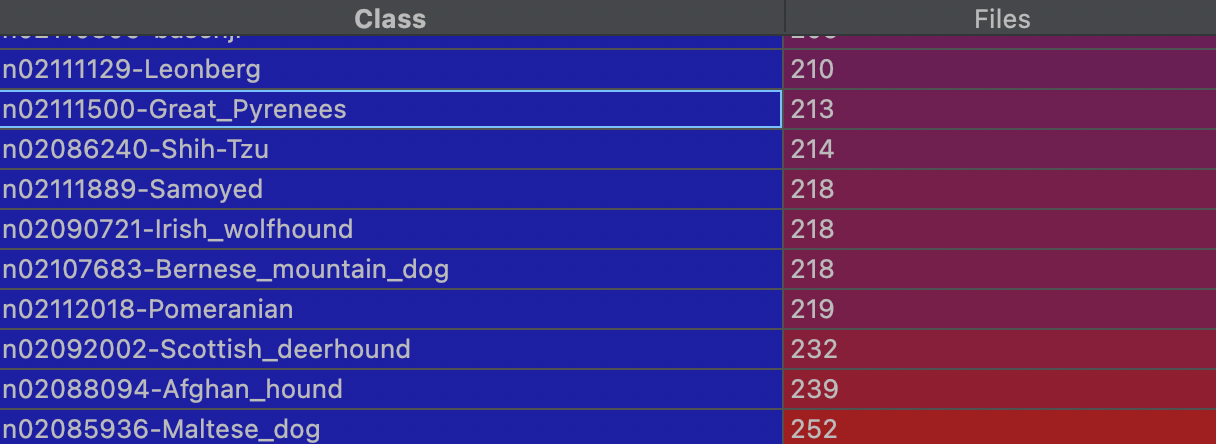

A este subconjunto de imágenes podéis acceder en el siguiente enlace: https://drive.google.com/file/d/1hyO3J5XiclTqgMD_-ITPRJfVtOQ1GhY6/view?usp=share_link

Si trabajáis desde Google Colab podéis descargar el archivo directamente desde mi Drive con el siguiente snippet de código:

```

# Importamos librerías para interactuar con Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Nos autenticamos con nuestra cuenta de Google Drive para acceder a los datos
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Nos descargamos las imagenes que vamos a emplear
download = drive.CreateFile({'id': '1hyO3J5XiclTqgMD_-ITPRJfVtOQ1GhY6'})
download.GetContentFile('StanfordDogsDataset.zip')

```

Para descomprimir el archivo podéis usar el código:

```
with zipfile.ZipFile('StanfordDogsDataset.zip', 'r') as zip_ref:
    zip_ref.extractall('StanfordDogsDataset')
```

Con esto entrena varios modelos:

1. Haciendo uso de transferencia de conocimiento.
2. Haciendo uso de aumento de datos (prueba con varios tipos de transformación para ver si te afecta al rendimiento).
3. Haciendo uso de transferencia de conocimiento y aumento de datos.

In [24]:
import tensorflow as tf
from keras.src.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import albumentations as A
from ImageDataAugmentor import ImageDataAugmentor
import numpy as np

IMG_SIZE = (256, 256, 3)
BATCH_SIZE = 32
RANDOM_STATE = 2_055
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SOURCE_PATH = './StanfordDogsDataset'

In [7]:
train_dataset = image_dataset_from_directory(
    IMAGE_SOURCE_PATH,
    validation_split=.2,
    subset="training",
    seed=RANDOM_STATE,
    image_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE
)

validation_dataset = image_dataset_from_directory(
    IMAGE_SOURCE_PATH,
    validation_split=.2,
    subset="validation",
    seed=RANDOM_STATE,
    image_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE
)

train_ds = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2233 files belonging to 10 classes.
Using 1787 files for training.
Found 2233 files belonging to 10 classes.
Using 446 files for validation.


In [8]:
def get_model():
    model_constructor = tf.keras.applications.inception_v3.InceptionV3
    preprocess = tf.keras.applications.inception_v3.preprocess_input

    model_base = model_constructor(include_top=False, weights='imagenet', input_shape=IMG_SIZE)
    model_base.trainable = False

    input_layer = layers.Input(IMG_SIZE)
    preprocess_layer = preprocess(input_layer)
    base_layer = model_base(preprocess_layer, training=False)
    flatter_layer = layers.Flatten()(base_layer)
    output_layer = layers.Dense(10, activation="softmax")(flatter_layer)

    model_built = Model(inputs=[input_layer], outputs=[output_layer])

    return model_built

In [34]:
def get_model_no_knowledge_transfer():
    input_layer = layers.Input(shape=IMG_SIZE)

    layer_conv_1 = layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding="same",
                                 activation="relu")(input_layer)
    layer_conv_2 = layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding="same",
                                 activation="relu")(layer_conv_1)

    pool_1 = layers.MaxPool2D(pool_size=(2, 2))(layer_conv_2)

    layer_conv_3 = layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(2, 2), padding="same",
                                 activation="relu")(pool_1)

    pool_2 = layers.MaxPool2D(pool_size=(2, 2))(layer_conv_3)

    layer_conv_4 = layers.Conv2D(filters=12, kernel_size=(7, 7), strides=(1, 1), padding="same",
                                 activation="relu")(pool_2)
    layer_conv_5 = layers.Conv2D(filters=12, kernel_size=(7, 7), strides=(1, 1), padding="same",
                                 activation="relu")(layer_conv_4)

    global_avg = layers.GlobalAveragePooling2D()(layer_conv_5)

    dense_hidden_1 = layers.Dense(64, activation='relu')(global_avg)
    dense_hidden_2 = layers.Dense(32, activation='relu')(dense_hidden_1)

    dense_output = layers.Dense(10, activation='softmax')(dense_hidden_2)

    model = Model(inputs=[input_layer], outputs=[dense_output])

    return model

In [9]:
def train_model(model, train_data, validation_data):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='./Practice02_NoAugmentation.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=True
    )

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, epochs=10, validation_data=validation_data,
                        callbacks=[model_checkpoint_callback], verbose=True)

    return history

In [20]:
def plot_losses(history):
    last_epoch_loss = history.history['loss'][-1]
    last_epoch_val_loss = history.history['val_loss'][-1]

    figure = plt.figure(figsize=(10, 8))

    axes = figure.add_subplot(1, 1, 1)

    axes.plot(history.history['loss'], color="#003B80", linestyle="dotted",
              label=f"loss entrenamiento {last_epoch_loss:.2f}")
    axes.plot(history.history['val_loss'], color="#003B80", label=f"loss validación {last_epoch_val_loss:.2f}")

    axes.set_xlabel('Época', color="#003B80", fontsize=14)
    axes.set_ylabel('Pérdidas', color="#003B80", fontsize=14)

    axes.set_title('Pérdidas durante el entrenamiento', fontsize=18)
    axes.set_facecolor('#F0F7FF')
    axes.legend(loc="best")
    axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)
    axes.set_axisbelow(True)
    axes.set_ylim(ymin=0, ymax=3.1)
    axes.yaxis.set_major_locator(MultipleLocator(0.3))

    return figure

In [10]:
model_no_augmentation = get_model()
model_no_augmentation.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                7372

In [11]:
history_no_augmentation = train_model(model_no_augmentation, train_ds, validation_ds)

Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 2.1031 - accuracy: 0.8590
Epoch 1: val_accuracy improved from -inf to 0.94843, saving model to .\Practice02_NoAugmentation.h5


C:\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 39s 651ms/step - loss: 2.1031 - accuracy: 0.8590 - val_loss: 1.2342 - val_accuracy: 0.9484
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.9720
Epoch 2: val_accuracy did not improve from 0.94843
56/56 [==============================] - 36s 635ms/step - loss: 0.3894 - accuracy: 0.9720 - val_loss: 2.3296 - val_accuracy: 0.9170
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9787
Epoch 3: val_accuracy did not improve from 0.94843
56/56 [==============================] - 35s 621ms/step - loss: 0.2495 - accuracy: 0.9787 - val_loss: 1.6196 - val_accuracy: 0.9395
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9855
Epoch 4: val_accuracy did not improve from 0.94843
56/56 [==============================] - 33s 595ms/step - loss: 0.1448 - accuracy: 0.9855 - val_loss: 1.7820 - val_accuracy: 0.9350
Epoch 5/10
56/56 [===================

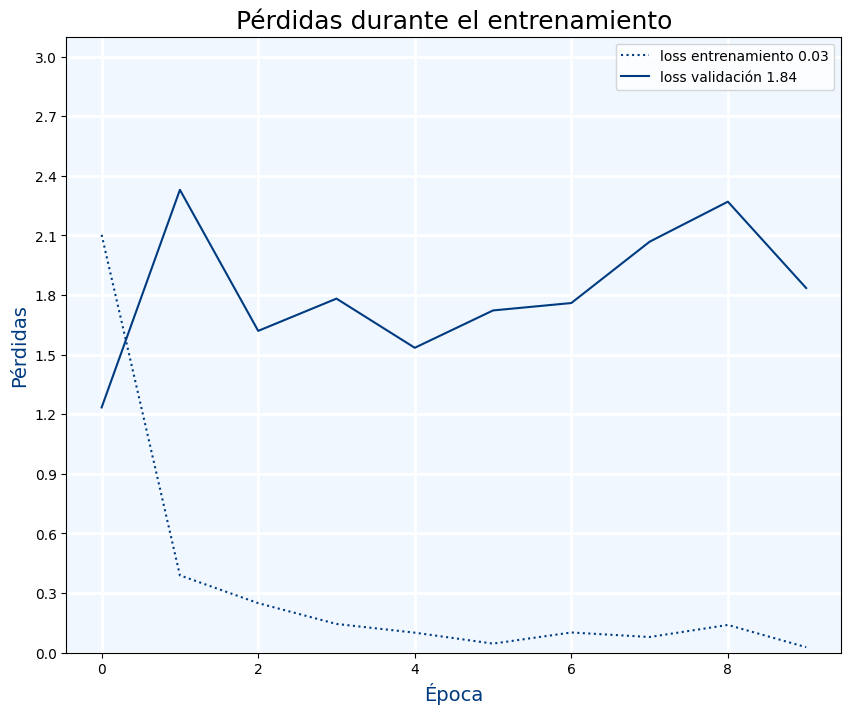

In [21]:
_ = plot_losses(history_no_augmentation)

# Data augmentation

In [29]:
def get_data_with_augmentation():
    # Implementamos la rutina de transformaciones
    transforms = A.Compose([
        A.HorizontalFlip(p=.5),
        A.VerticalFlip(p=.2),
        A.Rotate(limit=45, p=.8),
        A.RandomBrightnessContrast(brightness_limit=.8, contrast_limit=.8, p=.5),
        A.CLAHE(p=.5),
        A.Superpixels(p_replace=1, n_segments=1, p=.5)
    ])

    # Generador de datos de entrenamiento
    train_datagen = ImageDataAugmentor(
        augment=transforms,
        validation_split=0.2,
        seed=RANDOM_STATE
    )

    val_datagen = ImageDataAugmentor(
        validation_split=0.2,
        seed=RANDOM_STATE
    )

    train_dataset = train_datagen.flow_from_directory(
        IMAGE_SOURCE_PATH,
        subset="training",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True)

    # Dataset validación
    validation_dataset = val_datagen.flow_from_directory(
        IMAGE_SOURCE_PATH,
        subset="validation",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True
    )

    return train_dataset, validation_dataset

Found 1792 images belonging to 10 classes.
Found 441 images belonging to 10 classes.


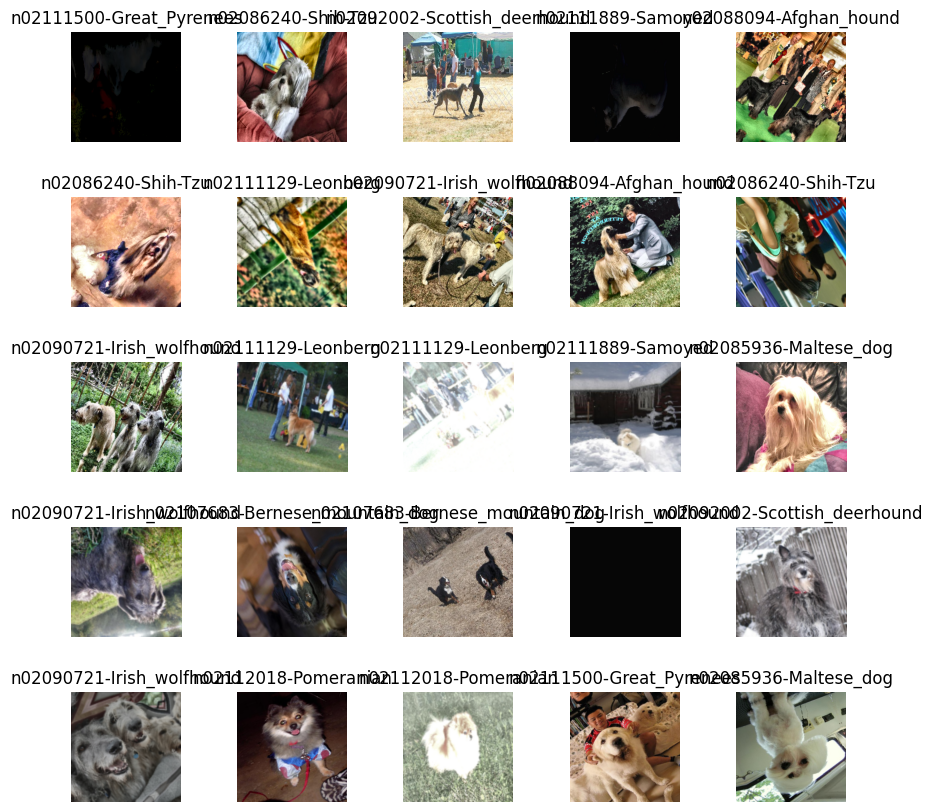

In [31]:
ds_train, ds_validation = get_data_with_augmentation()
ds_train.show_data()

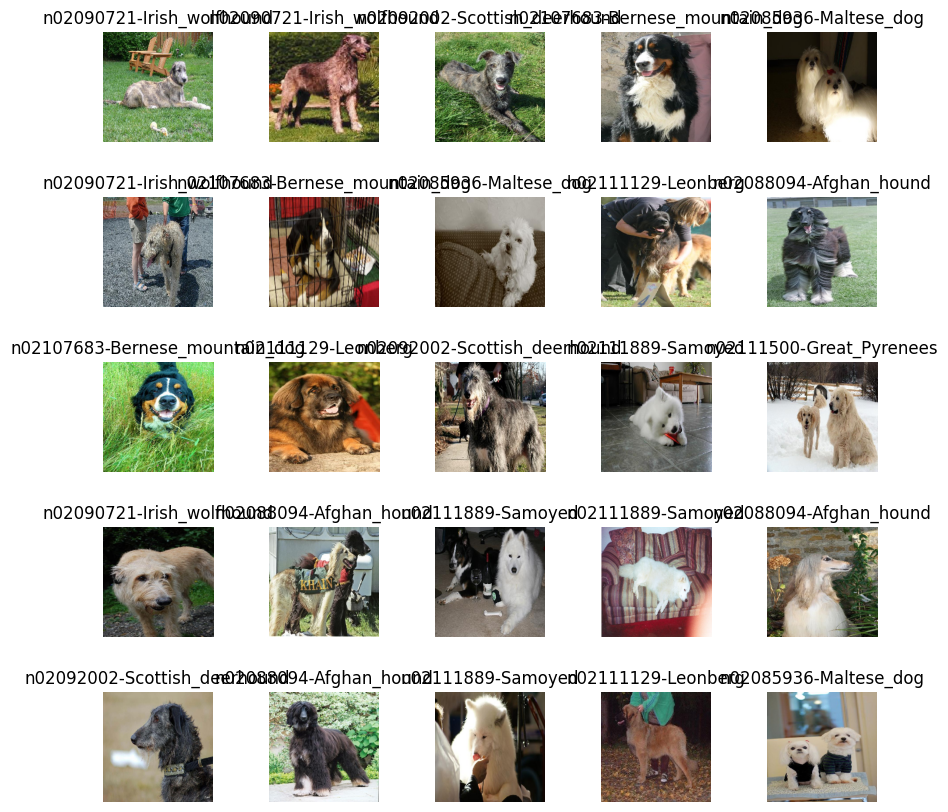

In [32]:
ds_validation.show_data()

In [36]:
model_data_aug = get_model_no_knowledge_transfer()
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='Practice02_WithAugmentation.h5',
                                                               monitor='val_accuracy', mode='max',
                                                               save_best_only=True,
                                                               verbose=1)

model_data_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_samples = ds_train.n
validation_samples = ds_validation.n
history_data_aug = model_data_aug.fit(ds_train,
                                      steps_per_epoch=train_samples // BATCH_SIZE,
                                      epochs=10,
                                      validation_data=ds_validation,
                                      validation_steps=validation_samples // BATCH_SIZE,
                                      callbacks=[model_checkpoint_callback],
                                      verbose=1)
np.save('Practice02_WithAugmentation_history_aug.npy', history_data_aug.history)

Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 2.3069 - accuracy: 0.1177
Epoch 1: val_accuracy improved from -inf to 0.12740, saving model to Practice02_WithAugmentation.h5
56/56 [==============================] - 18s 305ms/step - loss: 2.3069 - accuracy: 0.1177 - val_loss: 2.2962 - val_accuracy: 0.1274
Epoch 2/10


C:\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - ETA: 0s - loss: 2.2963 - accuracy: 0.1272
Epoch 2: val_accuracy improved from 0.12740 to 0.15385, saving model to Practice02_WithAugmentation.h5
56/56 [==============================] - 16s 290ms/step - loss: 2.2963 - accuracy: 0.1272 - val_loss: 2.2943 - val_accuracy: 0.1538
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 2.2955 - accuracy: 0.1228
Epoch 3: val_accuracy did not improve from 0.15385
56/56 [==============================] - 16s 288ms/step - loss: 2.2955 - accuracy: 0.1228 - val_loss: 2.2908 - val_accuracy: 0.1466
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 2.2942 - accuracy: 0.1300
Epoch 4: val_accuracy improved from 0.15385 to 0.18029, saving model to Practice02_WithAugmentation.h5
56/56 [==============================] - 16s 280ms/step - loss: 2.2942 - accuracy: 0.1300 - val_loss: 2.2794 - val_accuracy: 0.1803
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 2.2915 -

NameError: name 'np' is not defined

In [ ]:
_ = plot_losses(history_data_aug)